# CartPole with PER(Feat. DDQN)
---

In [1]:
import copy
import gym
from gym.core import ObservationWrapper

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from IPython.display import Video

# pygame 출력 안될시
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

/home/hyunseok.hwang/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = gym.make('CartPole-v1')
env._max_episode_steps=2000

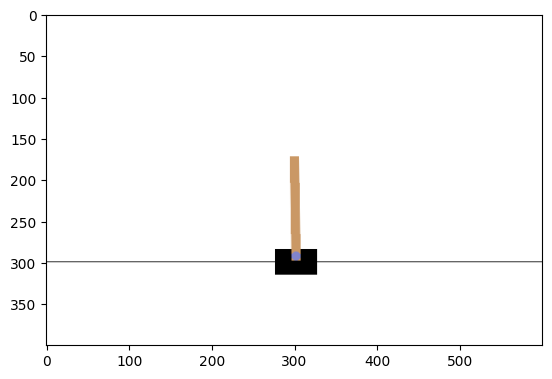

In [3]:
env.reset()
plt.imshow(env.render('rgb_array'))

In [4]:
class DQN_SimpleAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=1):
        super(DQN_SimpleAgent,self).__init__()
        self.epsilon = epsilon # Epsilon-decay를 진행할예정
        self.n_actions = n_actions
        self.state_shape = state_shape
    
        # 에이전트 인공신경망 디자인
        # 입력층 [batch,4] -> s(상태)
        # 입력 은닉층 출력층: 4, (64,32) , 2
        # 활성화 함수: 모두 relu
        #  64,32
        # 출력층 [batch,2] -> Q(s,a_왼쪽), Q(s,a_오른쪽)
        self.seq = nn.Sequential(
            nn.Linear(state_shape[-1],32),  # [batch,4] -> [batch, 64] 은닉 1층
            nn.ReLU(),
            nn.Linear(32,32), # [batch,64] -> [batch,32] 은닉 2층
            nn.ReLU(),
            nn.Linear(32,n_actions),  # [batch,32] -> [batch,2] 출력층
            nn.ReLU()         
        )
        
    def forward(self, state_t):
        '''
        Forward 함수(인공신경망 입.출력 함수)
            입력: state
            출력: Q(s,a)
        '''    
        qvalues = self.seq(state_t)
        return qvalues

    def get_actions(self, qvalues):
        '''
        [batch,action] 형태의 Q함수, epsilon값을 기준으로 Exploration vs Exploitation
        입력: 
            Q-함수, [batch, action]
        출력:
            최적행동, [batch]
        '''
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        return np.where(should_explore, random_actions, best_actions)    

Text(0.5, 1.0, 'Epsilon-decay curve')

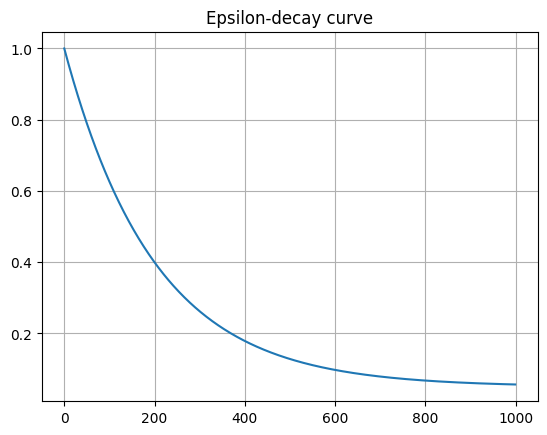

In [5]:
def epsilon_decay(t,eps_max=1,eps_min=0.05,eps_decay=200):
    return eps_min+(eps_max-eps_min)*np.exp(-1*t/eps_decay)

ts = np.arange(1000)

epsilon = []
for t in ts:
    eps = epsilon_decay(t)
    epsilon.append(eps)
plt.plot(epsilon)
plt.grid()
plt.title('Epsilon-decay curve')

In [6]:
a = np.array([5,3,1,2,4,6])
a[np.argsort(a)[-3:]]

array([4, 5, 6])

In [7]:
# PER: 랭크입력 방식
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py 에서 핵심 아이디어 채용
# + https://github.com/qfettes/DeepRL-Tutorials/blob/master/06.DQN_PriorityReplay.ipynb 에서 아이디어 채용
class PrioritizedReplayBuffer(object):
    def __init__(self,size,alpha=0.4,beta=0.6,beta_frames=100000,eps=1e-8):
        '''
        리플레이 버퍼 초기 설정
        입력: 
            size - 리플레이 버퍼의 크기. 버퍼크기를 넘어가면 선입선출로 이전데이터를 메모리상에서 없앰
            alpha - 선호도 이용도 지표. 높을수록 강한 선호도 이용
            beta - 메모리 loss 보정 지표. 높을수록 loss 보정 강하게 이용
            beta_frames - Annealing bias를 위한 정수
            eps - priority를 양수로 만들기 위한 epsilon값
        + Annealing bias -> 학습초기에는 loss보정 적게, 후기에는 loss보정 강하게 이용
        '''
        self._storage = []
        self._maxsize = size
        self._next_idx = 0
        
        # 숫자가 커질수록 메모리 추출에 우선순위
        self._max_priority = 1.
        self.priorities = []
        self.alpha = alpha
        self.beta = beta
        self.beta_frames = beta_frames
        self.frame = 1 # 학습 초기, 후기 판가름
        self.PER_eps = eps # priority - 양수로 만들기 위한 epsilon값
        
    def beta_by_frame(self,number):
        '''
        목적 - 샘플할떄마다 Beta값을 증가시키기 -> annealing
        입력
            number - 샘플링 한 횟수
        출력
            beta - 조정된 beta. 최대 1
        '''
        beta = min(1,self.beta + number*(1-self.beta)/self.beta_frames)
        return beta
    
    def __len__(self):
        return len(self._storage)
    
    def add(self,obs_t,action,reward,obs_tp,done):
        '''
        리플레이 버퍼에 데이터 추가
        입력: 
            obs_t - 현재관찰(상태)
            action - 현재액션
            reward - 보상
            obs_tp - 다음관찰(상태')
            done - 종료여부
            + 입력 당시에는 어떤 조건이었더라도 랭크는 최우선 순위
        '''
        data = (obs_t,action,reward,obs_tp,done)
        if self._next_idx >= len(self._storage):
            self._storage.append(data)
            self.priorities.append(self._max_priority)
        else:
            self._storage[self._next_idx] = data
            self.priorities[self._next_idx] = self._max_priority
        self._next_idx = int((self._next_idx + 1) % self._maxsize)
        
    def _encode_sample(self,idxes):
        '''
        리플레이 버퍼로부터 샘플링
        입력:
            idxes - 메모리에서 추출할 데이터 인덱스 [batch]
        출력:
            샘플된 데이터
        '''
        obs_ts, actions, rewards, obs_tps, dones = [],[],[],[],[]
        for idx in idxes:
            obs_t, action, reward, obs_tp, done = self._storage[idx]
            obs_ts.append(obs_t)
            actions.append(action)
            rewards.append(reward)
            obs_tps.append(obs_tp)
            dones.append(done)
        return (
                np.array(obs_ts),
                np.array(actions),
                np.array(rewards),
                np.array(obs_tps),
                np.array(dones)
            )
    def sample(self,batch_size):
        '''
        self._encode_sample을 호출할 함수
        메모리의 랭크에 따라 결정!
        입력: 
            batch_size - 배치사이즈(int)
        출력:
            self._encode_sample로 받는 batch
            idxes: 인덱스 번호 
            weights: Annealing bias
        '''
        # 인덱스 추출
        #idxes = np.random.randint(len(self._storage),size=batch_size)
        idxes = np.argsort(self.priorities)[-batch_size:]
        weights = []
        
        beta = self.beta_by_frame(self.frame)
        self.frame += 1
        
        p_min = np.min(self.priorities)/np.sum(self.priorities)
        max_weight = (p_min*len(self._storage))**(-beta)
        
        # paper 수식 
        for idx in idxes:
            p_sample = self.priorities[idx]
            weight = (p_sample*len(self._storage))**(-beta)
            weights.append(weight/max_weight)
        return self._encode_sample(idxes), idxes, weights
    
    def update_priorities(self,idxes,priorities):
        '''
        priorities 업데이트
        입력
            idxes: 메모리 인덱스
            priority: priority 값 - loss를 기준으로 설정
        '''
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes,priorities):
            assert 0 <= idx < len(self._storage)
            self.priorities[idx] = (priority+self.PER_eps)**self.alpha
            self._max_priority = max(self._max_priority, (priority+self.PER_eps))

In [8]:
# 하이퍼 파라미터 정의
env = gym.make('CartPole-v0')
env._max_episode_steps=2000

gamma=0.99
epsilon_start = 0.5
epsilon_sig=1000

state = env.reset()
num_state = state.shape
num_action = env.action_space.n
learning_rate = 1e-04
max_episode = 10000
num_random_init = 100
batch_size=32
model_update_period=100

# priotiry 설정
alpha = 0.4
beta_initial = 0.6
beta_frames=10000

/home/hyunseok.hwang/anaconda3/envs/torch/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [9]:
# A 신경망, B 신경망 생성
train_agent = DQN_SimpleAgent(state.shape,env.action_space.n,epsilon_start)
target_agent = DQN_SimpleAgent(state.shape,env.action_space.n,epsilon_start)
optimizer = optim.Adam(train_agent.parameters(),lr=learning_rate,weight_decay=1e-09)

target_agent.load_state_dict(train_agent.state_dict())

<All keys matched successfully>

In [10]:
replay_buffer = PrioritizedReplayBuffer(10000,alpha, beta_initial, beta_frames)
criterion = nn.MSELoss()

In [11]:
state = env.reset()
for _ in range(num_random_init):
    action = env.action_space.sample()
    next_state,reward,done,_ = env.step(action)
    replay_buffer.add(state,action,reward,next_state,done)
    if done:
        state = env.reset()
    state = next_state

In [12]:
def PER_DDQN_TD_loss(replay,train_agent,target_agent,env,gamma=gamma):
    '''
    TD loss함수 계산코드 (feat, PER)
    입력
        replay - 리플레이 버퍼
        train_agent - 훈련에이전트
        target_agent - 타겟에이전트
        env - 환경       
        gamma - 할인율
    출력
        loss - PER TD-error RMS
        sum(weights*(R+gamma*Q_{target}(s,argmaxQ_{train}(s,a))-Q_{train}(s,a))**2)/n
    '''
    batch_sample,idxes,weights = replay_buffer.sample(batch_size)
    states,actions,rewards,next_states,dones = batch_sample

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.ByteTensor(dones)
    not_dones = 1-dones
    
    train_Q = train_agent(states)
    train_actions = torch.argmax(train_Q,dim=-1)
    train_Q = train_Q[range(len(actions)), actions]
    
    target_Q = target_agent(next_states)
    target_Q = target_Q[range(len(actions)),train_actions]
    
    TD_target = rewards+not_dones*gamma*target_Q
    loss = TD_target.detach()-train_Q
    loss_weight = torch.FloatTensor(weights)*loss**2
    replay_buffer.update_priorities(idxes,torch.abs(loss).detach().cpu().numpy().tolist())
    loss_weight = torch.mean(loss_weight)
    return loss_weight

700번째 에피소드 결과
Epsilon: 0.07868751425120257
최근 50 에피소드 보상평균 = 158.86
최근 50 에피소드 TD오차 = 4.2970627767090186e-07


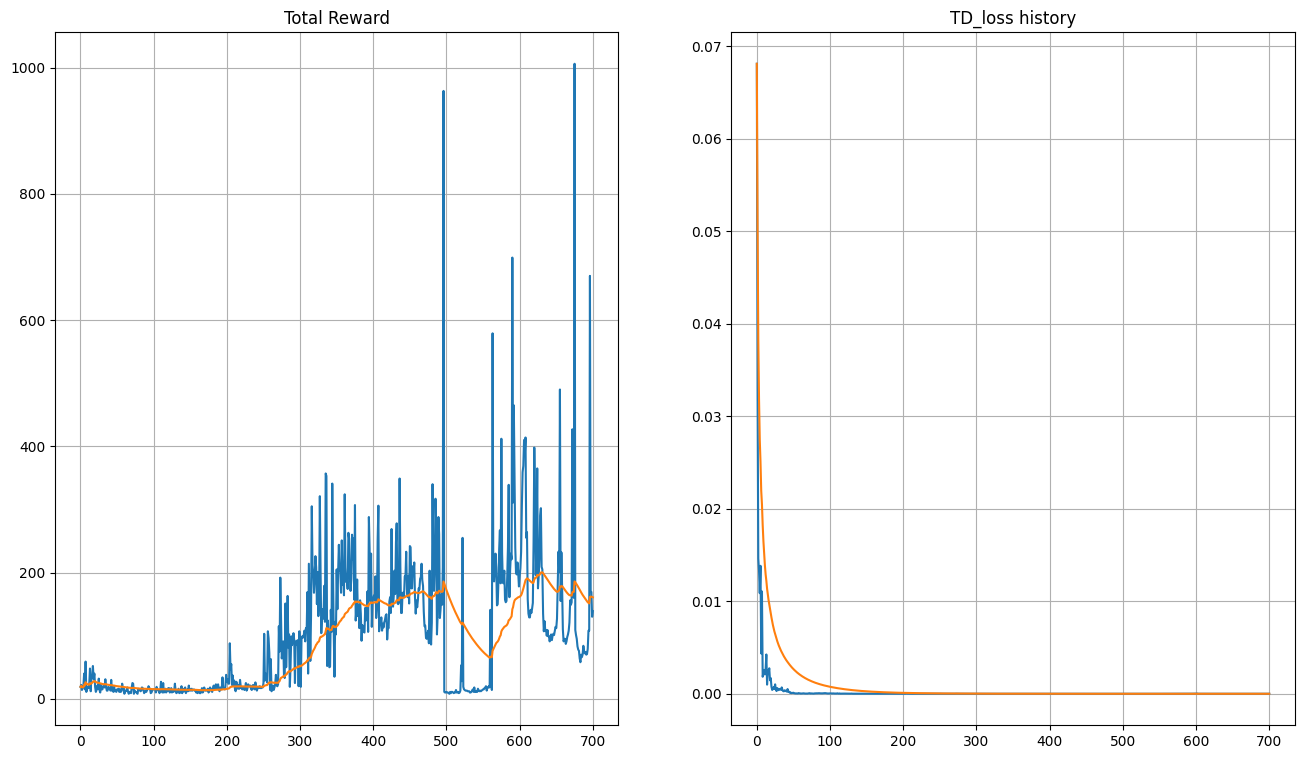

충분한 보상: 1620.0
학습종료


In [13]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

reward_record, TDloss_record = [], []
cnt = 0

for ep in range(max_episode):
    done = False
    state = env.reset()
    
    total_reward = 0
    mean_episode_TD = 0
    while True:
        torch_state = torch.FloatTensor(state)
        qvalues = train_agent(torch.unsqueeze(torch_state,0)) 
        action = train_agent.get_actions(qvalues)
        
        next_state,reward,done,_ = env.step(action[0])
        replay_buffer.add(state,action[0],reward,next_state,done)
        
        loss = PER_DDQN_TD_loss(replay_buffer,train_agent,target_agent,env,gamma=gamma)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_episode_TD += loss.item()
        total_reward += reward
        
        if cnt % model_update_period == 0:
            target_agent.load_state_dict(train_agent.state_dict())
            
        if done:
            mean_episode_TD /= cnt    
            TDloss_record.append(mean_episode_TD)
            reward_record.append(total_reward)
            if total_reward >= 1500:
                best_agent = copy.deepcopy(train_agent)
            break
        
        # 업데이트
        state = next_state
        train_agent.epsilon = epsilon_decay(ep,eps_max=1,eps_min=0.05,eps_decay=200)
        cnt += 1
    #break
    if ep % 50 == 0:
        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'Epsilon: {train_agent.epsilon}')
        print(f'최근 50 에피소드 보상평균 = {np.mean(reward_record[-50:])}')
        print(f'최근 50 에피소드 TD오차 = {np.mean(TDloss_record[-50:])}')
        
        plt.figure(figsize=[16, 9])
        
        plt.subplot(1,2,1)
        plt.title("Total Reward")
        plt.plot(reward_record)
        plt.plot(moving_average(reward_record))
        plt.grid()
        
        plt.subplot(1,2,2)
        plt.title("TD_loss history")
        plt.plot(TDloss_record)
        plt.plot(moving_average(TDloss_record))
        plt.grid()
        
        plt.show()
    
    if np.max(reward_record[-50:]) >= 1500:
        print(f"충분한 보상: {np.max(reward_record[-50:])}")
        print(f"학습종료")
        break

In [14]:
# 비디오를 저장해보겠습니다.
torch.save(best_agent,'./ckpt/CartPole/PER_CartPole_bestmodel.pth')
#train_agent = torch.load('./ckpt/CartPole/PER_CartPole_bestmodel.pth')

In [15]:
import gym.wrappers

def record(initial_state,agent,env,vid):
    state = initial_state
    sum_rewards = 0

    while True:
        vid.capture_frame()
        #env.render()
        torch_state = torch.FloatTensor(state)
        qvalues = train_agent(torch.unsqueeze(torch_state,0))
        action = train_agent.get_actions(qvalues)

        next_state,reward,done,_ = env.step(action[0])
        
        state = next_state
        sum_rewards += reward
        if done:
            break
    vid.close()
    return sum_rewards

env = gym.make('CartPole-v0')
env._max_episode_steps=2000
vid = gym.wrappers.monitoring.video_recorder.VideoRecorder(env,path='./videos/CartPole/PER_CartPole_video.mp4')
vid.render_mode="rgb_array"
state = env.reset()
rewards = record(state,train_agent,env,vid)

/home/hyunseok.hwang/anaconda3/envs/torch/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/home/hyunseok.hwang/anaconda3/envs/torch/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(


In [16]:
from IPython.display import Video

Video('./videos/CartPole/PER_CartPole_video.mp4',embed=True,width=512, height=512)